#### Last Modified: July 26th, 2022 (Opal).

## sOpInf Applied to MAS Full Sun (3D) Solar Wind Radial Speed Dataset for CR2210


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy
import scipy.linalg as la
from scipy import signal
from scipy import  stats
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from MHD.notebook_functions import regularizer
from scipy.interpolate import RegularGridInterpolator
import time
import astropy.units as u
import cv2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

### Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [6]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

# save radial velocity 
V = np.array(f)

In [8]:
V.shape

(129, 111, 140)

### Background:  Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [9]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

In [10]:
v1 = V[:, :, 0]

shift_vec = [0]

for ii in range(1, len(r)):
    v2 = V[:, :, ii]
    corr = periodic_corr_2d(v1, v2)
    shift_vec.append(-p[np.argmax(corr)]*180/np.pi)

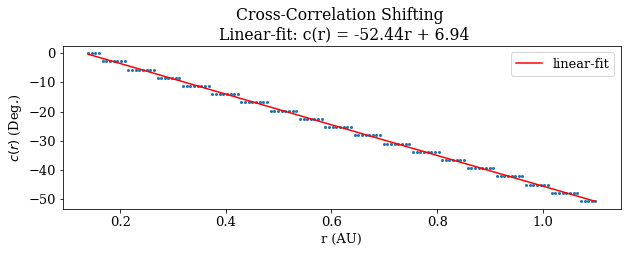

In [11]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=4)

n = int(len(r)*0.7)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: c(r) = " + str(round(m, 2)) + "r + " + str(round(b, 2)))

In [12]:
def shift_function(r, m, b):
    return m * r + b

In [13]:
def interp_fun(p_shifted, p, t, v):
    # interpolator. 
    my_interpolating_function = RegularGridInterpolator((p, t), v)
    # create new mesh grid. 
    points = np.meshgrid(p_shifted, t)
    # flatten the mesh grid points to align with input for RegularGridInterp function.
    flat = np.array([m.flatten() for m in points])
    # pass to the interp function.
    out_array = my_interpolating_function(flat.T)
    # reshape back to original grid. 
    return out_array.reshape(*points[0].shape)

In [14]:
# initialize the data matrix. 
V_new = np.zeros((len(p), len(t), len(r)))

# initial conditon. 
V_new[:, :, 0] = V[:, :, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi + shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=V[:, :, jj]).T

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [15]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [16]:
X=V_new

In [17]:
X_train = V_new[:,:, :l]
X_test = V_new[:,:, l:]

In [18]:
r_train = r[:l]
r_test = r[l:]

In [19]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 111, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 111, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

### Linear Model of the form: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{A}\hat{\mathbf{v}}(r)$
First, we seek a reduced model with that same structure,
$$
    \frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{A}\hat{\mathbf{v}}(r),\qquad\hat{\mathbf{v}}(r_{0}) = \hat{\mathbf{v}}_{r_{0}},
$$

but with $\hat{\mathbf{v}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Essentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind radial velocity at several heliocentric distances. 

In [20]:
def flatten(X):
    return X.reshape((len(p)*len(t), -1))
    

def undo_flatten(X):
    return X.reshape(len(p), len(t), -1)

def convert_from_x_to_v(X_ROM):
    # intialize the returned matrix. 
    V_ROM = np.zeros(X_ROM.shape)
    # initial condition
    V_ROM[:,:, 0] = X_ROM[:,:, 0]
    # iterate over all r slices. 
    for jj in range(1, len(r)):
        # compute shift from the linear fit above. 
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # define the new shifted coordinate.
        x_new = (p*180/np.pi - shift) % (360)
        # interpolate over the shifted coordinate
        V_ROM[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=X_ROM[:, :, jj]).T
    return V_ROM

In [21]:
rank = 8 # initialize the rank of ROM
Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank)        # Construct the reduced basis.                       
Xdot_ = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) # Estimate the projected time derivatives.
model = roi.InferredContinuousROM("A")
model.fit(Vr, flatten(X_train), Xdot_, P=10**(3))
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF")

### Evaluating the Performance of the ROM

In [22]:
V_ROM_A = convert_from_x_to_v(undo_flatten(X_ROM))

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_74029/3084451170.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


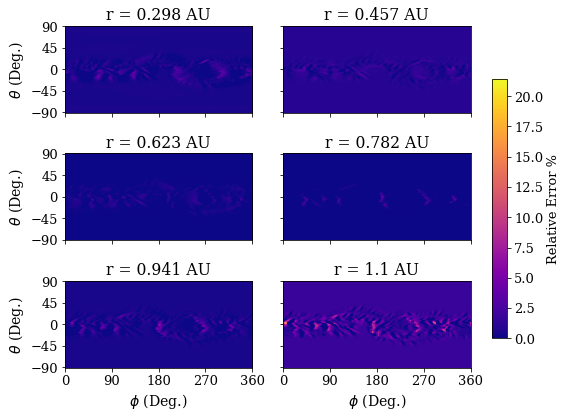

In [23]:
RE = (V_ROM_A -V)/(V)
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([1*len(r)//6, 3*len(r)//6,  len(r)-1 - len(r)//6], start=0):
    
    im = ax[id_subplot][0].imshow(100*RE[:, :, snapshot].T,  vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(100*RE[:, :, snapshot + len(r)//6].T, vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot + len(r)//6].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)

#ax[0][0].set_title("MHD \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
#ax[0][1].set_title("S-OpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("Relative Error %", rotation=90)


plt.tight_layout()

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_74029/2735142641.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


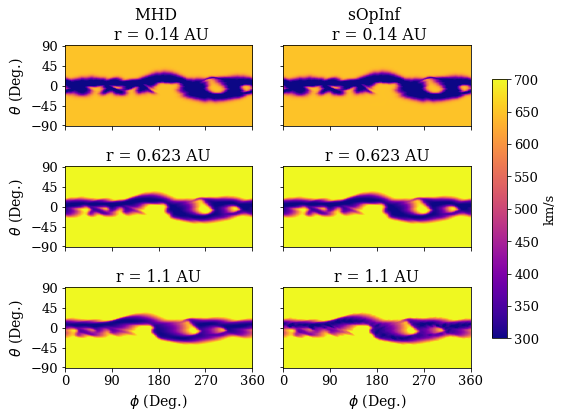

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([0, len(r)//2, len(r)-1], start=0):
    im = ax[id_subplot][0].imshow(f[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(V_ROM_A[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[0][0].set_title("MHD \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
ax[0][1].set_title("sOpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("km/s", rotation=90)


plt.tight_layout()

In [25]:
print("PCC Training = ", stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM_A[:, :, :l]))[0])
print("PCC Testing = ", stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM_A[:, :, l:]))[0])

print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :, :l] - V_ROM_A[:,:,  :l])/np.abs(V[:, :, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :, :l] - V_ROM_A[:, :, :l])/np.abs(V[:, :, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :, :l] - V_ROM_A[:, :, :l])/np.abs(V[:,:, :l])))

print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, :, l:] - V_ROM_A[:, :, l:])/np.abs(V[:,:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, :, l:] - V_ROM_A[:, :, l:])/np.abs(V[:, :, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, :, l:] - V_ROM_A[:, :,l:])/np.abs(V[:,:, l:])))

PCC Training =  0.9995488801342489
PCC Testing =  0.9993938127104809
Training RE (mean) % 0.579700302364494
Training RE (median) % 0.4699739316756303
Training RE (max) % 7.496877204079176
Testing RE (mean) % 0.7619565104550071
Testing RE (median) % 0.5329393687624457
Testing RE (max) % 21.399800331233358


### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$.

In [26]:
coeff1_array = 10**np.arange(0, 15)

training_error = np.ones(len(coeff1_array)) * np.inf
testing_error = np.ones(len(coeff1_array)) * np.inf

for kk, coeff1 in enumerate(coeff1_array):
    Vr, _ = roi.pre.pod_basis(flatten(X_train), r=8) 
    Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) 
    model = roi.InferredContinuousROM(modelform="A") 
    model.fit(Vr, flatten(X_train), Xdot, P=coeff1) 
    X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF") 
    X_ROM = undo_flatten(X_ROM)

    if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
        V_ROM = convert_from_x_to_v(X_ROM)
        # save
        training_error[kk] = np.max(np.abs(V[:, :, :l]-V_ROM[:, :, :l])/V[:, :, :l])
        # save
        testing_error[kk] = np.max(np.abs(V[:, :, l:]-V_ROM[:, :, l:])/V[:, :, l:])

In [27]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff1_array[idx[0]]))

Training lambda = 3.0


In [28]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff1_array[idx[0]]))

Testing lambda = 4.0


# Quadratic ROM 
$$\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{H} (\hat{\mathbf{v}}(r) \otimes \hat{\mathbf{v}}(r))$$

In [29]:
rank = 8 # initialize the rank of ROM
Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank)        # Construct the reduced basis.                       
Xdot_ = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) # Estimate the projected time derivatives.
model = roi.InferredContinuousROM("H")
model.fit(Vr, flatten(X_train), Xdot_, P=10**(8))
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF")
V_ROM_H = convert_from_x_to_v(undo_flatten(X_ROM))

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_74029/289031672.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


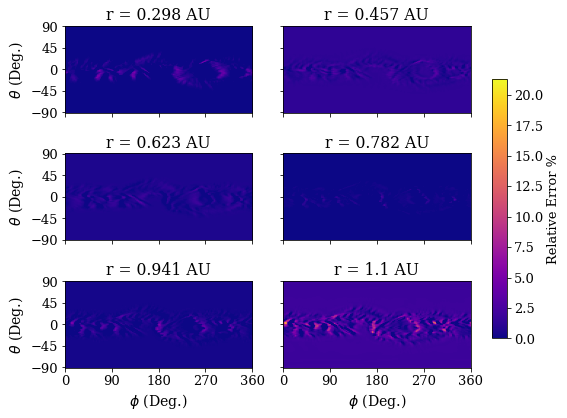

In [30]:
RE = (V_ROM_H -V)/(V)
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([1*len(r)//6, 3*len(r)//6,  len(r)-1 - len(r)//6], start=0):
    
    im = ax[id_subplot][0].imshow(100*RE[:, :, snapshot].T,  vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(100*RE[:, :, snapshot + len(r)//6].T, vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot + len(r)//6].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("Relative Error %", rotation=90)


plt.tight_layout()

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_74029/2900629055.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


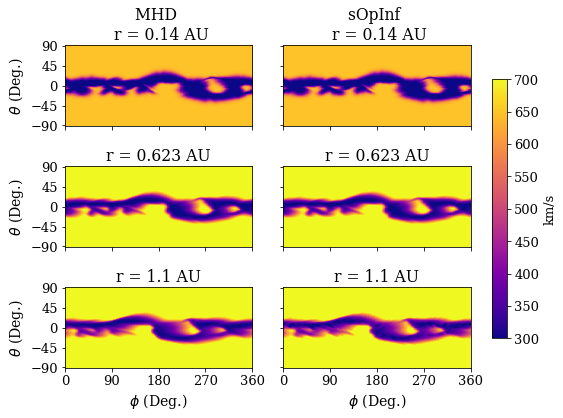

In [31]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([0, len(r)//2, len(r)-1], start=0):
    im = ax[id_subplot][0].imshow(f[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(V_ROM_H[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[0][0].set_title("MHD \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
ax[0][1].set_title("sOpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("km/s", rotation=90)


plt.tight_layout()

In [32]:
print("PCC Training = ", stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM_H[:, :, :l]))[0])
print("PCC Testing = ", stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM_H[:, :, l:]))[0])

print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :, :l] - V_ROM_H[:,:,  :l])/np.abs(V[:, :, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :, :l] - V_ROM_H[:, :, :l])/np.abs(V[:, :, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :, :l] - V_ROM_H[:, :, :l])/np.abs(V[:,:, :l])))

print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, :, l:] - V_ROM_H[:, :, l:])/np.abs(V[:,:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, :, l:] - V_ROM_H[:, :, l:])/np.abs(V[:, :, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, :, l:] - V_ROM_H[:, :,l:])/np.abs(V[:,:, l:])))

PCC Training =  0.9993121271293072
PCC Testing =  0.9993379075530869
Training RE (mean) % 0.7350910460835358
Training RE (median) % 0.7137082457896602
Training RE (max) % 8.250370779963562
Testing RE (mean) % 0.7371651233317233
Testing RE (median) % 0.4356961642981813
Testing RE (max) % 21.27929797452883


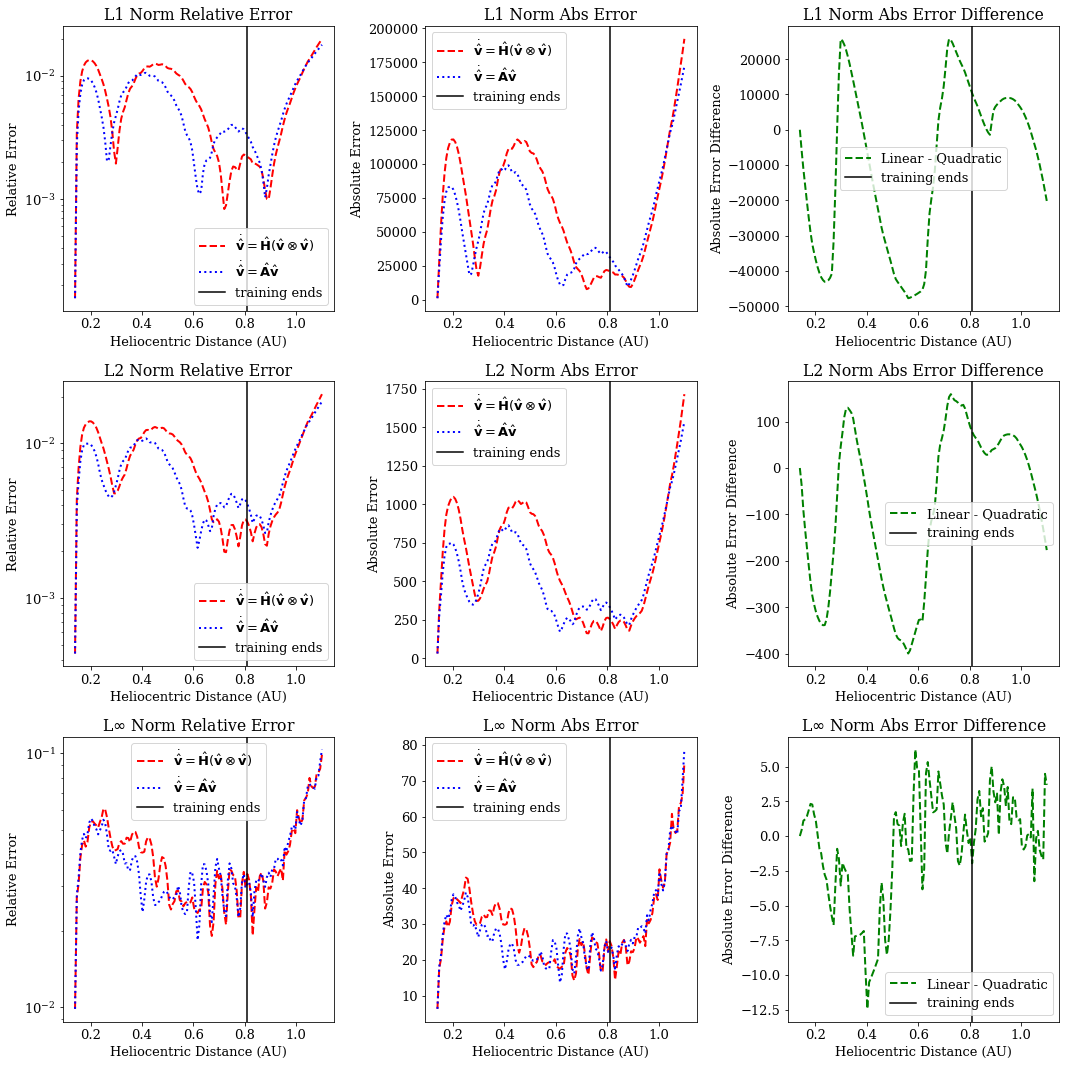

In [33]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

for ii in range(0, 3):
    if ii ==2:
        norm=np.inf
    else:
        norm=ii+1
    abs_l2errA, rel_l2errA = roi.post.lp_error(flatten(V), flatten(V_ROM_A), p=norm)
    abs_l2errH, rel_l2errH = roi.post.lp_error(flatten(V), flatten(V_ROM_H), p=norm)

    _ = ax[ii, 0].plot(r.to(u.AU).value, rel_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 0].plot(r.to(u.AU).value, rel_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")

    _ = ax[ii, 0].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 0].set_title(r"L$\infty$ Norm Relative Error")
    else:
        _ = ax[ii, 0].set_title(r"L" + str(ii+1)+ " Norm Relative Error")
    _ = ax[ii, 0].set_yscale("log")  
    _ = ax[ii, 0].set_ylabel("Relative Error", c="k")
    _ = ax[ii, 0].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 0].legend()

    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii, 1].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 1].set_title(r"L$\infty$ Norm Abs Error")
    else:
        _ = ax[ii, 1].set_title(r"L" + str(ii+1)+ " Norm Abs Error")
    
    _ = ax[ii, 1].set_ylabel("Absolute Error", c="k")
    _ = ax[ii, 1].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 1].legend()


    _ = ax[ii, 2].plot(r.to(u.AU).value, abs_l2errA - abs_l2errH,"--", linewidth=2, c="green", label="Linear - Quadratic")

    _ = ax[ii, 2].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 2].set_title(r"L$\infty$ Norm Abs Error Difference")
    else:
        _ = ax[ii, 2].set_title(r"L" + str(ii+1)+ " Norm Abs Error Difference")
    _ = ax[ii, 2].set_ylabel("Absolute Error Difference", c="k")
    _ = ax[ii, 2].set_xlabel("Heliocentric Distance (AU)")
    _ = ax[ii, 2].legend()

plt.tight_layout()

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$.

In [34]:
coeff1_array = 10**np.arange(0, 15)

training_error = np.ones(len(coeff1_array)) * np.inf
testing_error = np.ones(len(coeff1_array)) * np.inf

for kk, coeff1 in enumerate(coeff1_array):
    Vr, _ = roi.pre.pod_basis(flatten(X_train), r=8) 
    Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) 
    model = roi.InferredContinuousROM(modelform="H") 
    model.fit(Vr, flatten(X_train), Xdot, P=coeff1) 
    X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF") 
    X_ROM = undo_flatten(X_ROM)

    if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
        V_ROM = convert_from_x_to_v(X_ROM)
        # save
        training_error[kk] = np.max(np.abs(V[:, :, :l]-V_ROM[:, :, :l])/V[:, :, :l])
        # save
        testing_error[kk] = np.max(np.abs(V[:, :, l:]-V_ROM[:, :, l:])/V[:, :, l:])

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


In [35]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda =",  np.log10(coeff1_array[idx[0]]))

Training lambda = 8.0


In [36]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff1_array[idx[0]]))


Testing lambda = 9.0


### Quadratic + Linear ROM 
$$\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{c} + \hat{A}\hat{\mathbf{v}}(r) +\hat{H} (\hat{\mathbf{v}}(r) \otimes \hat{\mathbf{v}}(r))$$

In [37]:
rank=8
Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank) # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH") # Define the model structure.
model.fit(Vr, flatten(X_train), Xdot, P=regularizer(rank, 10**(4), 10**(8))) # Construct the ROM with Operator Inference.
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF") # Simulate the ROM.
V_ROM_cAH = convert_from_x_to_v(undo_flatten(X_ROM))

In [38]:
print("PCC Training = ", stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM_cAH[:, :, :l]))[0])
print("PCC Testing = ", stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM_cAH[:, :, l:]))[0])

print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :, :l] - V_ROM_cAH[:,:,  :l])/np.abs(V[:, :, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :, :l] - V_ROM_cAH[:, :, :l])/np.abs(V[:, :, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :, :l] -V_ROM_cAH[:, :, :l])/np.abs(V[:,:, :l])))

print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, :, l:] - V_ROM_cAH[:, :, l:])/np.abs(V[:,:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, :, l:] - V_ROM_cAH[:, :, l:])/np.abs(V[:, :, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, :, l:] - V_ROM_cAH[:, :,l:])/np.abs(V[:,:, l:])))

PCC Training =  0.9996994271214409
PCC Testing =  0.9996445525505652
Training RE (mean) % 0.45128894419260324
Training RE (median) % 0.33411843036623595
Training RE (max) % 7.731185314532681
Testing RE (mean) % 0.5399756352704778
Testing RE (median) % 0.35344956543300426
Testing RE (max) % 20.492587879575865


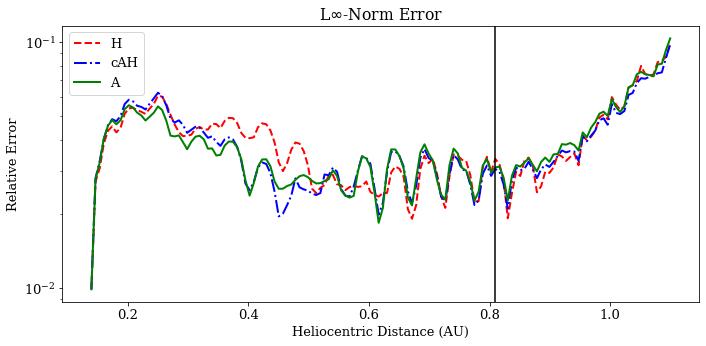

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(flatten(V), flatten(V_ROM_cAH), p=np.inf)
abs_l2errA, rel_l2errA = roi.post.lp_error(flatten(V), flatten(V_ROM_A), p=np.inf)
abs_l2errH, rel_l2errH = roi.post.lp_error(flatten(V), flatten(V_ROM_H), p=np.inf)

_ = ax.plot(r.to(u.AU).value, rel_l2errH,"--", linewidth=2, c="r", label="H")
_ = ax.plot(r.to(u.AU).value, rel_l2errcAH,"-.", linewidth=2, c="b", label="cAH")
_ = ax.plot(r.to(u.AU).value, rel_l2errA,"-", linewidth=2, c="g", label="A")

_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L$\infty$-Norm Error")
_ = ax.set_ylabel("Relative Error", c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.yscale("log")
plt.tight_layout()
plt.legend()

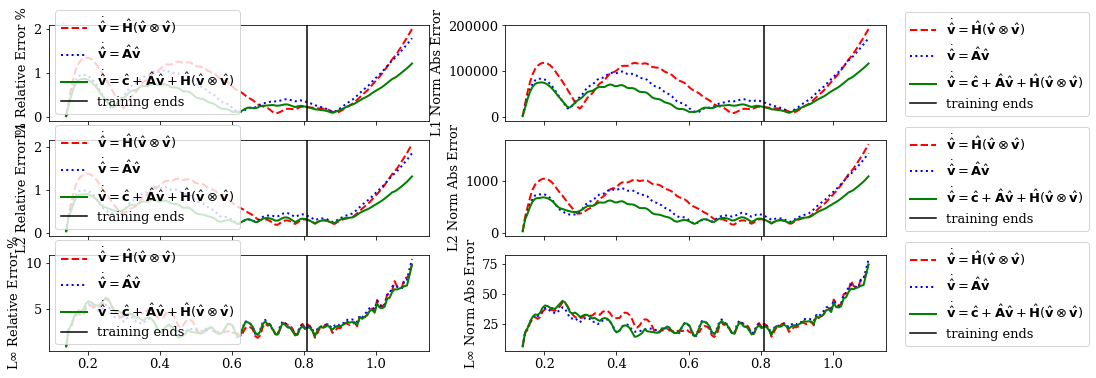

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(15, 6))
plt.rcParams['figure.constrained_layout.use'] = True

for ii in range(0, 3):
    if ii ==2:
        norm=np.inf
    else:
        norm=ii+1
    abs_l2errA, rel_l2errA = roi.post.lp_error(flatten(V), flatten(V_ROM_A), p=norm)
    abs_l2errH, rel_l2errH = roi.post.lp_error(flatten(V), flatten(V_ROM_H), p=norm)
    abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(flatten(V), flatten(V_ROM_cAH), p=norm)

    _ = ax[ii, 0].plot(r.to(u.AU).value, 100*rel_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 0].plot(r.to(u.AU).value, 100*rel_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii, 0].plot(r.to(u.AU).value, 100*rel_l2errcAH,"-", linewidth=2, c="g", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 0].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 0].set_ylabel("L$\infty$ Relative Error %", c="k")
    else:
        _ = ax[ii, 0].set_ylabel(r"L" + str(ii+1)+" Relative Error %", c="k")
    _ = ax[ii, 0].legend()

    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errH,"--", linewidth=2, c="r",
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errA,":", linewidth=2, c="b", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
    _ = ax[ii, 1].plot(r.to(u.AU).value, abs_l2errcAH,"-", linewidth=2, c="g", 
                label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
    _ = ax[ii, 1].axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
    if norm == np.inf:
        _ = ax[ii, 1].set_ylabel(r"L$\infty$ Norm Abs Error", c="k")
    else:
        _ = ax[ii, 1].set_ylabel(r"L" + str(ii+1)+ " Norm Abs Error", c="k")
    _ = ax[ii, 1].legend(loc=(1.05, .05))

#plt.subplots_adjust(hspace = -1)
#plt.tight_layout()

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_74029/3863340358.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


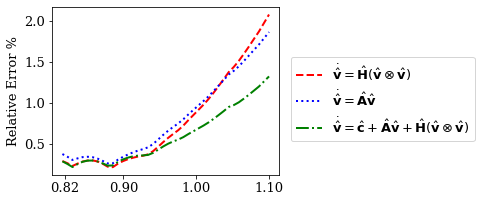

In [42]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(7,3))

norm=2
abs_l2errA, rel_l2errA = roi.post.lp_error(flatten(V), flatten(V_ROM_A), p=norm)
abs_l2errH, rel_l2errH = roi.post.lp_error(flatten(V), flatten(V_ROM_H), p=norm)
abs_l2errcAH, rel_l2errcAH = roi.post.lp_error(flatten(V), flatten(V_ROM_cAH), p=norm)

_ = ax.plot(r[l:].to(u.AU).value, 100*rel_l2errH[l:],"--", linewidth=2, c="r",
            label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
_ = ax.plot(r[l:].to(u.AU).value, 100*rel_l2errA[l:],":", linewidth=2, c="b", 
            label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}} \hat{\mathbf{v}} $")
_ = ax.plot(r[l:].to(u.AU).value, 100*rel_l2errcAH[l:],"-.", linewidth=2, c="g", 
            label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{c}} + \hat{\mathbf{A}} \hat{\mathbf{v}}+ \hat{\mathbf{H}} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")
#_ = ax.axvline(r_train[-1].to(u.AU).value, c="k", label="training ends")
#_ = ax.set_xticks([0.14, 0.5, round(r[l].to(u.AU).value, 2), 1.1])
_ = ax.set_ylabel(r"Relative Error %", c="k")
_ = ax.legend(loc=(1.05, .2))
_ = ax.set_xticks([0.82, 0.9, 1, 1.1])
plt.tight_layout()

plt.savefig("MHD/figs/model_form/MAS_full_sun_comparison_model_form.png", dpi=600)